In [1]:
import copy

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
from drmdp import feats
from drmdp.envs import gem

In [5]:
rf = gem.PositiveEnforcementWeightedSumOfErrors(penalty_gamma=1.0)

In [6]:
env = gem.make("Finite-CC-PMSM-v0", reward_fn="default", max_episode_steps=1000)
env

<TimeLimit<DiscretiseActionWrapper<GemObsAsVectorWrapper<FiniteCurrentControlPermanentMagnetSynchronousMotorEnv<Finite-CC-PMSM-v0>>>>>

In [7]:
def get_sample(size: int):
    starting_states = []
    for _ in range(size):
        obs, _ = env.reset()
        starting_states.append(obs)
    return np.stack(starting_states)

In [8]:
starting_states = get_sample(10_000)

In [9]:
starting_states.shape

(10000, 5)

In [10]:
df_so = pd.DataFrame(
    {str(col): starting_states[:, col] for col in range(starting_states.shape[1])}
)

In [11]:
df_so

,0,1,2,3,4
0,0.266041,0.016697,0.0,0.0,0.0
1,0.266041,0.016697,0.0,0.0,0.0
2,0.267848,0.018656,0.0,0.0,0.0
3,0.238400,0.075915,0.0,0.0,0.0
4,0.192052,0.146912,0.0,0.0,0.0
...,...,...,...,...,...
9995,0.054427,0.223306,0.0,0.0,0.0
9996,0.270393,0.158428,0.0,0.0,0.0
9997,0.286264,0.093690,0.0,0.0,0.0
9998,0.166434,0.030439,0.0,0.0,0.0


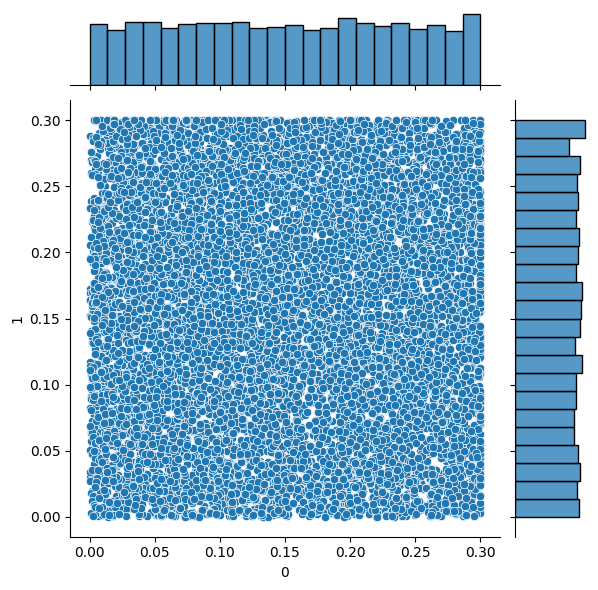

In [12]:
sns.jointplot(data=df_so, x="0", y="1")

In [13]:
env.observation_space.low, env.observation_space.high

(array([ 0.,  0., -1., -1.,  0.]), array([0.8, 0.8, 1. , 1. , 1. ]))

In [14]:
def play(env, num_episodes: int, feat_transform):
    init_obs = []
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        init_obs.append(obs)
        rewards = 0
        while True:
            action = env.action_space.sample()
            (
                next_obs,
                reward,
                term,
                trunc,
                _,
            ) = env.step(action)
            rewards += reward
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
    return init_obs, returns

In [15]:
def collect_return_sample(env, size: int):
    feat_transform = feats.create_feat_transformer(
        env, **{"name": "scale", "args": None}
    )
    init_obs, returns = play(env, num_episodes=size, feat_transform=feat_transform)
    return init_obs, returns

In [16]:
collect_return_sample(env, size=10)

([array([0.25222848, 0.26476648, 0.        , 0.        , 0.        ]),
  array([0.1666643 , 0.17041861, 0.        , 0.        , 0.        ]),
  array([0.03814534, 0.14908933, 0.        , 0.        , 0.        ]),
  array([0.26145659, 0.15273723, 0.        , 0.        , 0.        ]),
  array([0.212008  , 0.18952852, 0.        , 0.        , 0.        ]),
  array([0.22231117, 0.16069591, 0.        , 0.        , 0.        ]),
  array([0.02413306, 0.25197002, 0.        , 0.        , 0.        ]),
  array([0.04953161, 0.07862952, 0.        , 0.        , 0.        ]),
  array([0.23895394, 0.13939382, 0.        , 0.        , 0.        ]),
  array([0.1239305 , 0.24734511, 0.        , 0.        , 0.        ])],
 [-230.19921372777,
  -158.94604611704125,
  -129.98623252067546,
  -173.09268931698566,
  -63.74189199586357,
  -139.40449706764232,
  -154.34937112826876,
  -269.8582385380643,
  -278.9042391632519,
  -163.29888488909867])

## Reward Patterns

In [17]:
MAX_STEPS = 1000

In [18]:
def collect_reward_sample(reward_fn, size: int):
    env = gem.make(
        "Finite-CC-PMSM-v0",
        reward_fn=reward_fn,
        max_episode_steps=MAX_STEPS,
        constraint_violation_reward=-100,
    )
    obs, _ = env.reset()
    logs = []
    num_steps = 0
    while num_steps < size:
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(action)
        logs.append((copy.copy(obs), action, copy.copy(next_obs), reward))
        obs = next_obs
        done = term or trunc
        num_steps += 1

        if (num_steps + 1) % (size // 5) == 0:
            print("Step", num_steps + 1)

        if done:
            obs, _ = env.reset()
    env.close()
    return logs

In [19]:
default_rew_logs = collect_reward_sample(reward_fn="default", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [20]:
default_rew_logs[:5]

[(array([0.01822367, 0.27707001, 0.        , 0.        , 0.        ]),
  7,
  array([ 1.82246692e-02,  2.77276246e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  -0.14775045751642665),
 (array([ 1.82246692e-02,  2.77276246e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  4,
  array([ 0.00329539,  0.27693498,  0.0189061 , -0.00085112,  0.        ]),
  -0.14011518302459539),
 (array([ 0.00329539,  0.27693498,  0.0189061 , -0.00085112,  0.        ]),
  7,
  array([ 0.01657859,  0.27845883,  0.01888653, -0.00128094,  0.        ]),
  -0.14751870884362953),
 (array([ 0.01657859,  0.27845883,  0.01888653, -0.00128094,  0.        ]),
  5,
  array([ 0.02275318,  0.27397614,  0.02814744, -0.00679245,  0.        ]),
  -0.14836465668636822),
 (array([ 0.02275318,  0.27397614,  0.02814744, -0.00679245,  0.        ]),
  4,
  array([ 0.01250913,  0.26642698,  0.04697813, -0.00730864,  0.        ]),
  -0.13946805807602225)]

In [21]:
pos_rew_logs = collect_reward_sample(reward_fn="pos-enf", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [22]:
pos_rew_logs[:5]

[(array([0.27073521, 0.25253344, 0.        , 0.        , 0.        ]),
  7,
  array([ 2.70736216e-01,  2.52327206e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  1.738468289009115),
 (array([ 2.70736216e-01,  2.52327206e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  6,
  array([0.26599817, 0.25729494, 0.00952275, 0.00421339, 0.        ]),
  1.7383534433094652),
 (array([0.26599817, 0.25729494, 0.00952275, 0.00421339, 0.        ]),
  2,
  array([2.69746490e-01, 2.72994432e-01, 2.23011337e-04, 8.86462776e-03,
         0.00000000e+00]),
  1.7286295391203557),
 (array([2.69746490e-01, 2.72994432e-01, 2.23011337e-04, 8.86462776e-03,
         0.00000000e+00]),
  7,
  array([0.26895779, 0.28055784, 0.00030712, 0.00845058, 0.        ]),
  1.7252421841185217),
 (array([0.26895779, 0.28055784, 0.00030712, 0.00845058, 0.        ]),
  5,
  array([0.26327556, 0.28655828, 0.00962232, 0.00294618, 0.        ]),
  1.7250830814015985)]

In [23]:
highpenalty_rew_logs = collect_reward_sample(reward_fn="esp-neg", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [24]:
highpenalty_rew_logs[:5]

[(array([0.08172525, 0.26679293, 0.        , 0.        , 0.        ]),
  7,
  array([ 8.17242455e-02,  2.66999168e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  -0.17436170668529502),
 (array([ 8.17242455e-02,  2.66999168e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  4,
  array([ 0.10892205,  0.26776384,  0.0189061 , -0.00085112,  0.        ]),
  -0.1883429466481416),
 (array([ 0.10892205,  0.26776384,  0.0189061 , -0.00085112,  0.        ]),
  5,
  array([ 0.12193455,  0.27006348,  0.02822057, -0.0063541 ,  0.        ]),
  -0.19599901427325467),
 (array([ 0.12193455,  0.27006348,  0.02822057, -0.0063541 ,  0.        ]),
  4,
  array([ 0.14983708,  0.27077592,  0.04705617, -0.00685293,  0.        ]),
  -0.21030650127946887),
 (array([ 0.14983708,  0.27077592,  0.04705617, -0.00685293,  0.        ]),
  5,
  array([ 0.154119  ,  0.27377266,  0.05619958, -0.01239819,  0.        ]),
  -0.2139458330475739)]

In [25]:
def logs_as_dataframe(rew_logs, tag):
    obs, actions, next_obs, rewards = zip(*rew_logs)
    df_rw_logs = pd.DataFrame(
        {"obs": obs, "action": actions, "next_obs": next_obs, "reward": rewards}
    )
    df_rw_logs["fn"] = tag
    return df_rw_logs

In [26]:
df_obs_rew = pd.concat(
    [
        logs_as_dataframe(default_rew_logs, tag="default"),
        logs_as_dataframe(pos_rew_logs, tag="pos-enf"),
        logs_as_dataframe(highpenalty_rew_logs, tag="esp-neg"),
    ]
)

In [27]:
df_obs_rew

,obs,action,next_obs,reward,fn
0,"[0.018223666016785864, 0.2770700116285832, 0.0...",7,"[0.018224669181560745, 0.27727624585129257, -2...",-0.147750,default
1,"[0.018224669181560745, 0.27727624585129257, -2...",4,"[0.0032953905152142172, 0.27693497553397656, 0...",-0.140115,default
2,"[0.0032953905152142172, 0.27693497553397656, 0...",7,"[0.016578589858797364, 0.2784588278284617, 0.0...",-0.147519,default
3,"[0.016578589858797364, 0.2784588278284617, 0.0...",5,"[0.022753176543777225, 0.2739761368289592, 0.0...",-0.148365,default
4,"[0.022753176543777225, 0.2739761368289592, 0.0...",4,"[0.012509133245708223, 0.26642698290633626, 0....",-0.139468,default
...,...,...,...,...,...
9995,"[0.17455605033888671, 0.1923801138792975, -0.1...",6,"[0.17734639328951557, 0.19530522272209963, -0....",-0.186326,esp-neg
9996,"[0.17734639328951557, 0.19530522272209963, -0....",5,"[0.19992411715906533, 0.20056854361433712, -0....",-0.200246,esp-neg
9997,"[0.19992411715906533, 0.20056854361433712, -0....",7,"[0.17759092797505716, 0.20676162398872686, -0....",-0.192176,esp-neg
9998,"[0.17759092797505716, 0.20676162398872686, -0....",4,"[0.1736082315023482, 0.21337192887008033, -0.1...",-0.193490,esp-neg


## State ~ Reward

In [28]:
def plot_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4 * len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "reward", "fn"]])
        df_subplot["obs"] = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        sns.scatterplot(data=df_subplot, x="obs", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

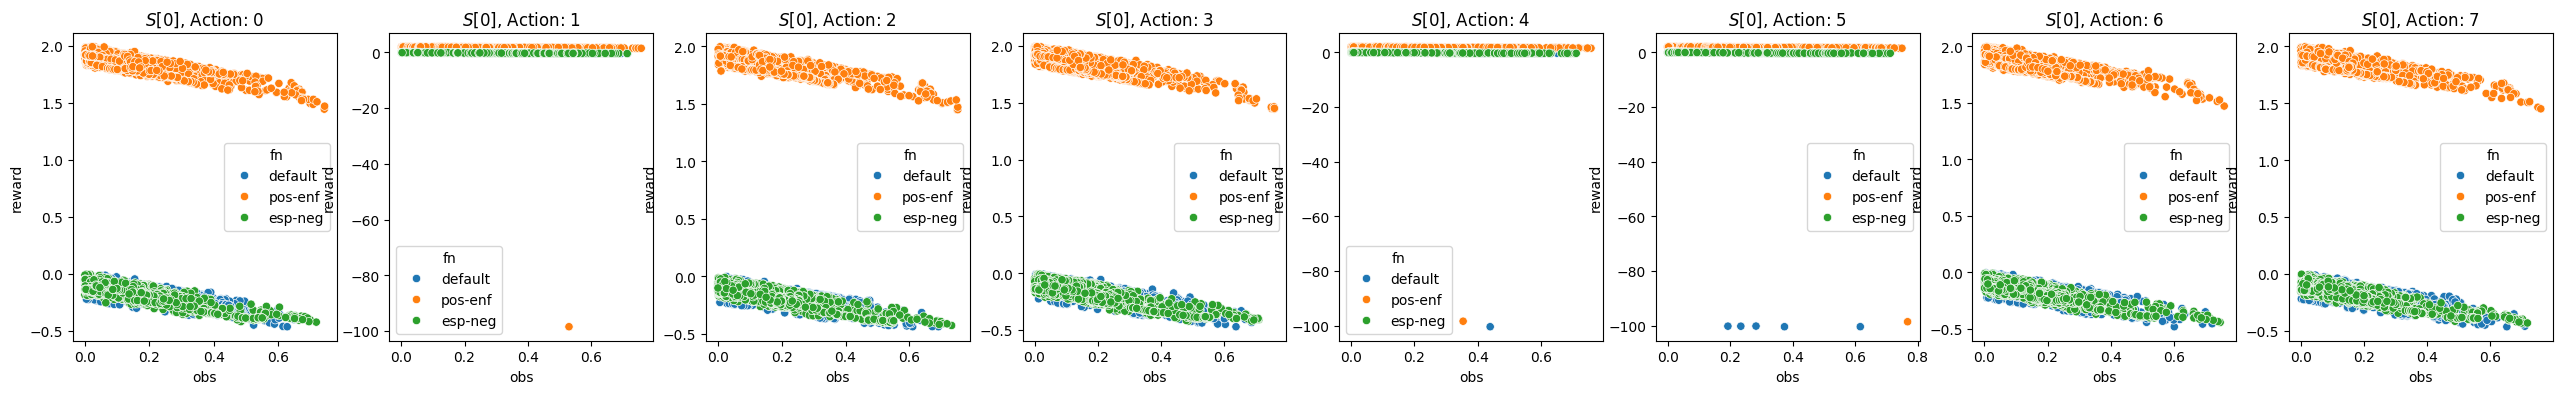

In [29]:
plot_rewards(df_obs_rew, state_idx=0)

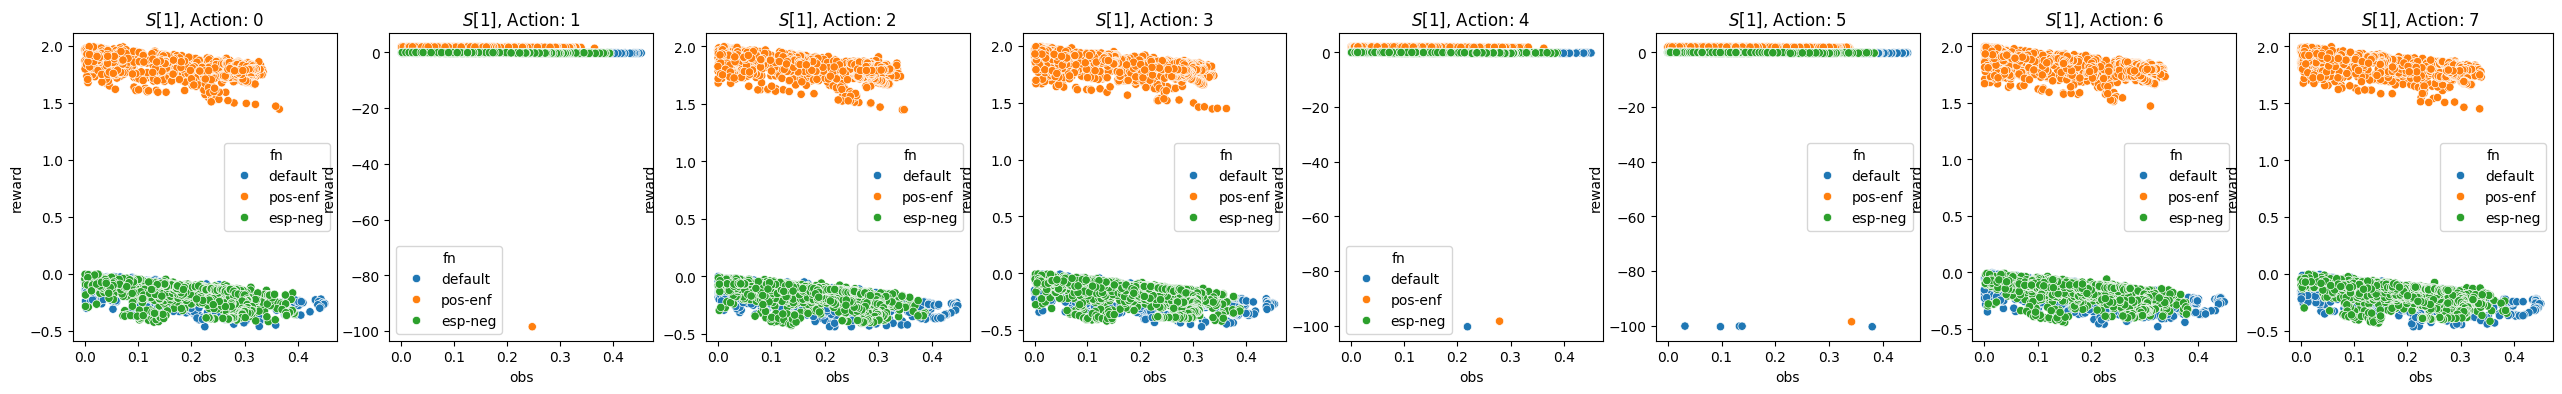

In [30]:
plot_rewards(df_obs_rew, state_idx=1)

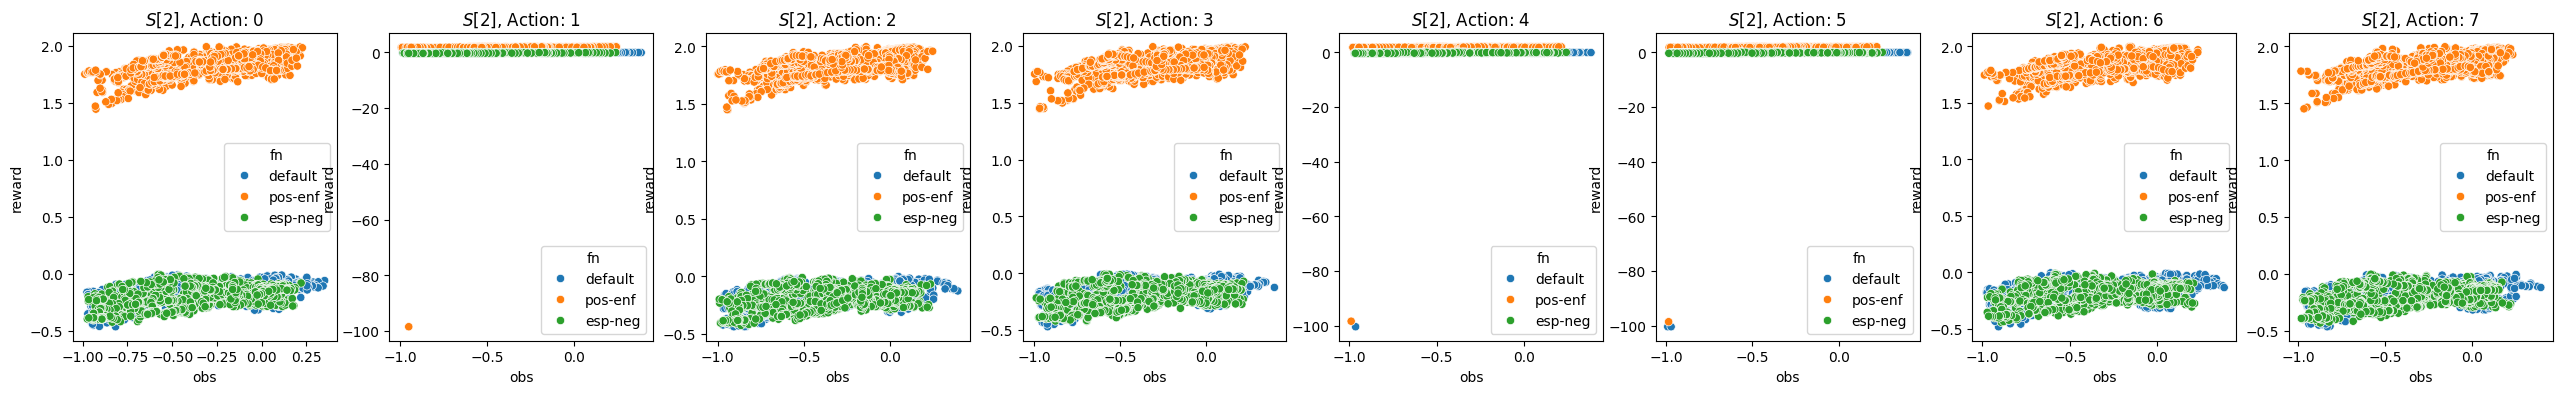

In [31]:
plot_rewards(df_obs_rew, state_idx=2)

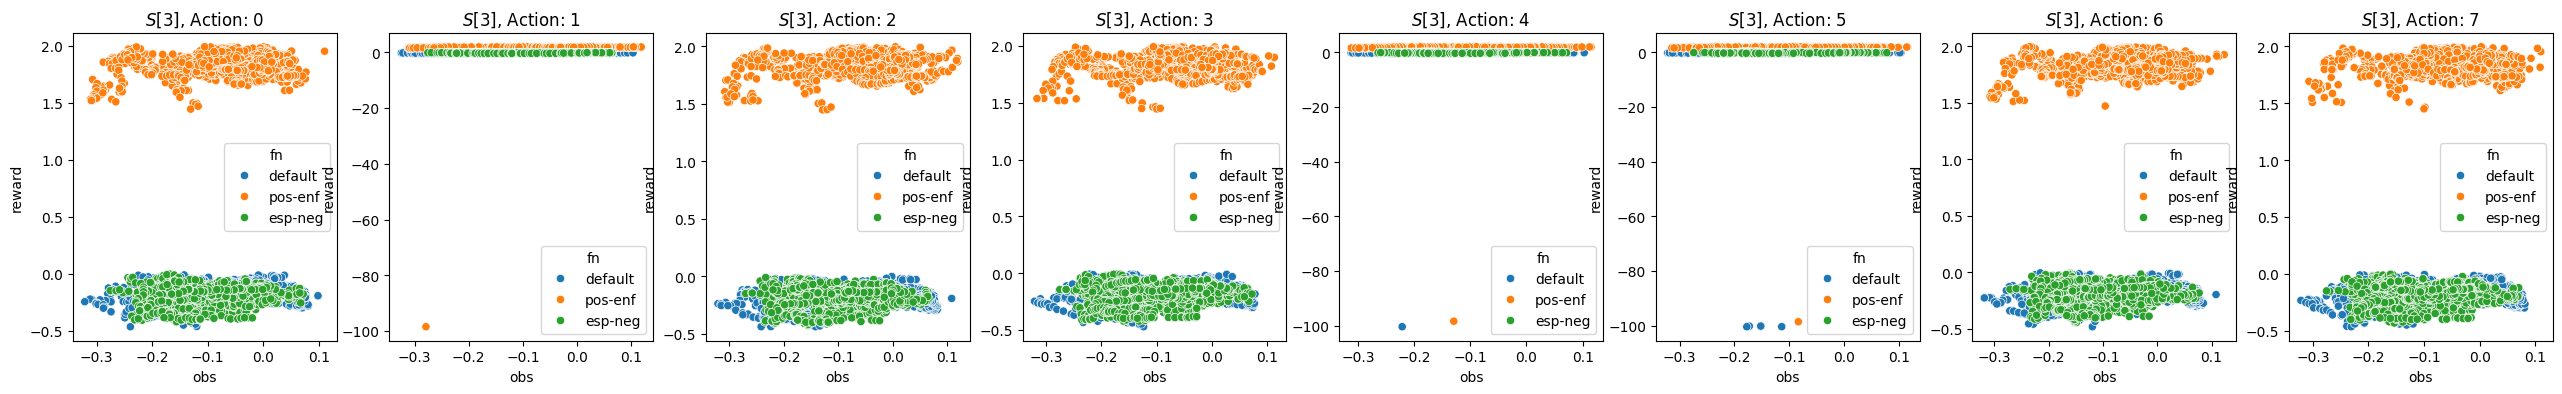

In [32]:
plot_rewards(df_obs_rew, state_idx=3)

## State $\Delta$ ~ Reward

In [33]:
def plot_state_change_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4 * len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "next_obs", "reward", "fn"]])
        obs = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        next_obs = df_subplot["next_obs"].apply(lambda xs: xs[state_idx])
        df_subplot["state_delta"] = next_obs - obs
        sns.scatterplot(data=df_subplot, x="state_delta", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

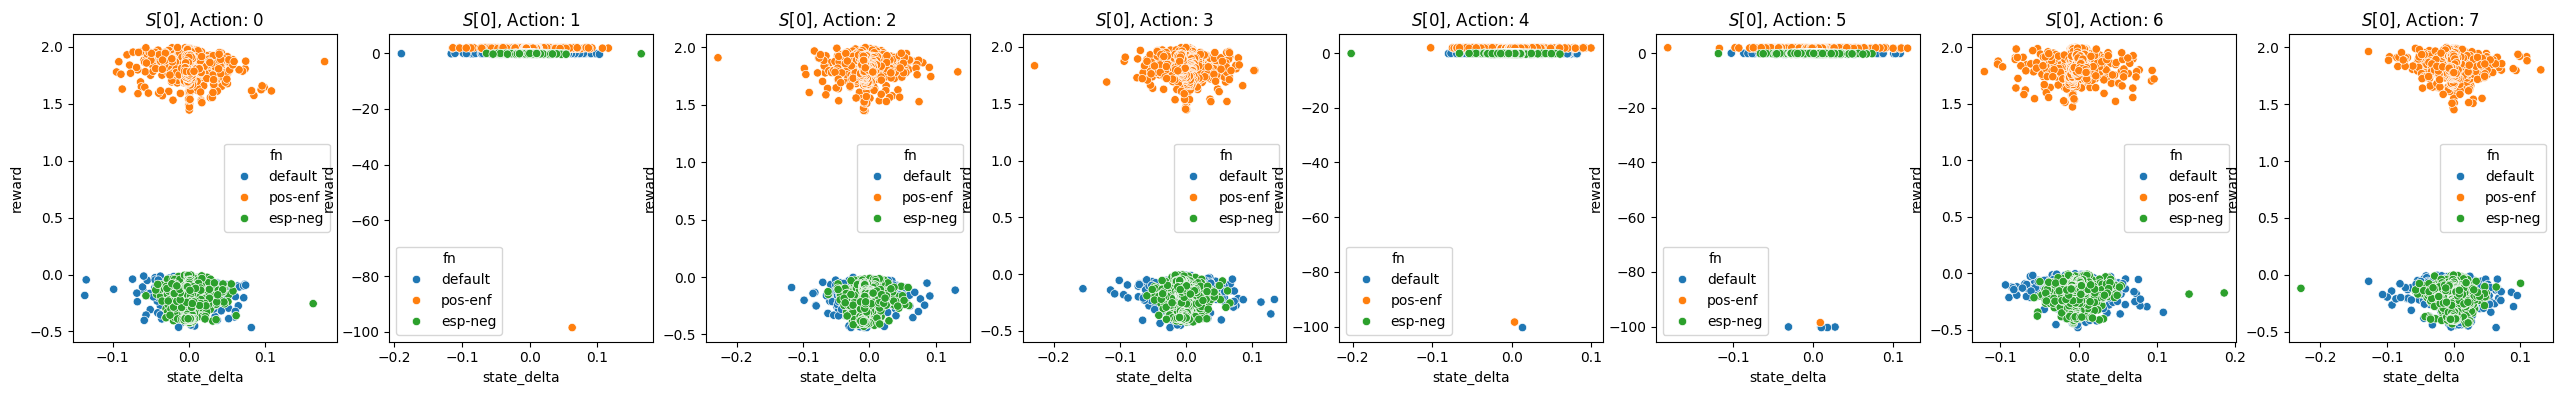

In [34]:
plot_state_change_rewards(df_obs_rew, state_idx=0)

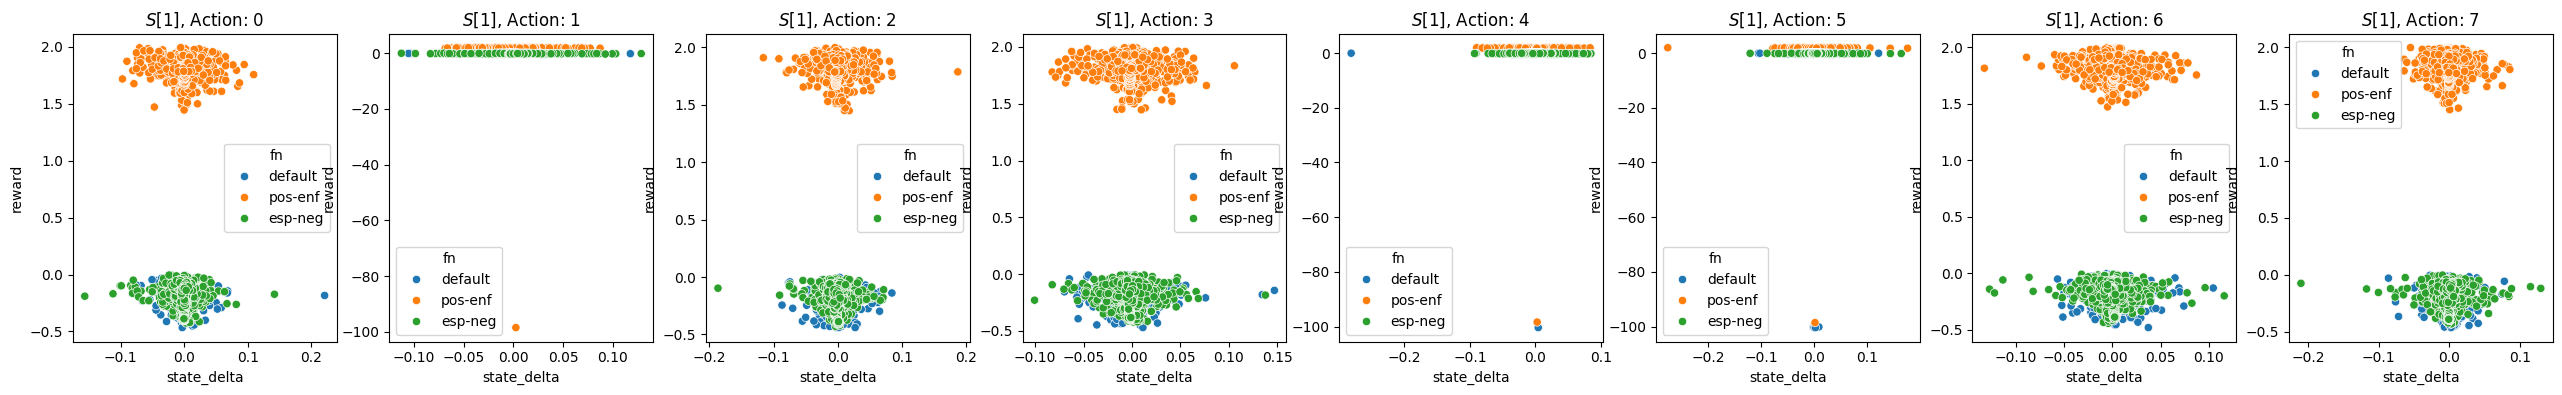

In [35]:
plot_state_change_rewards(df_obs_rew, state_idx=1)

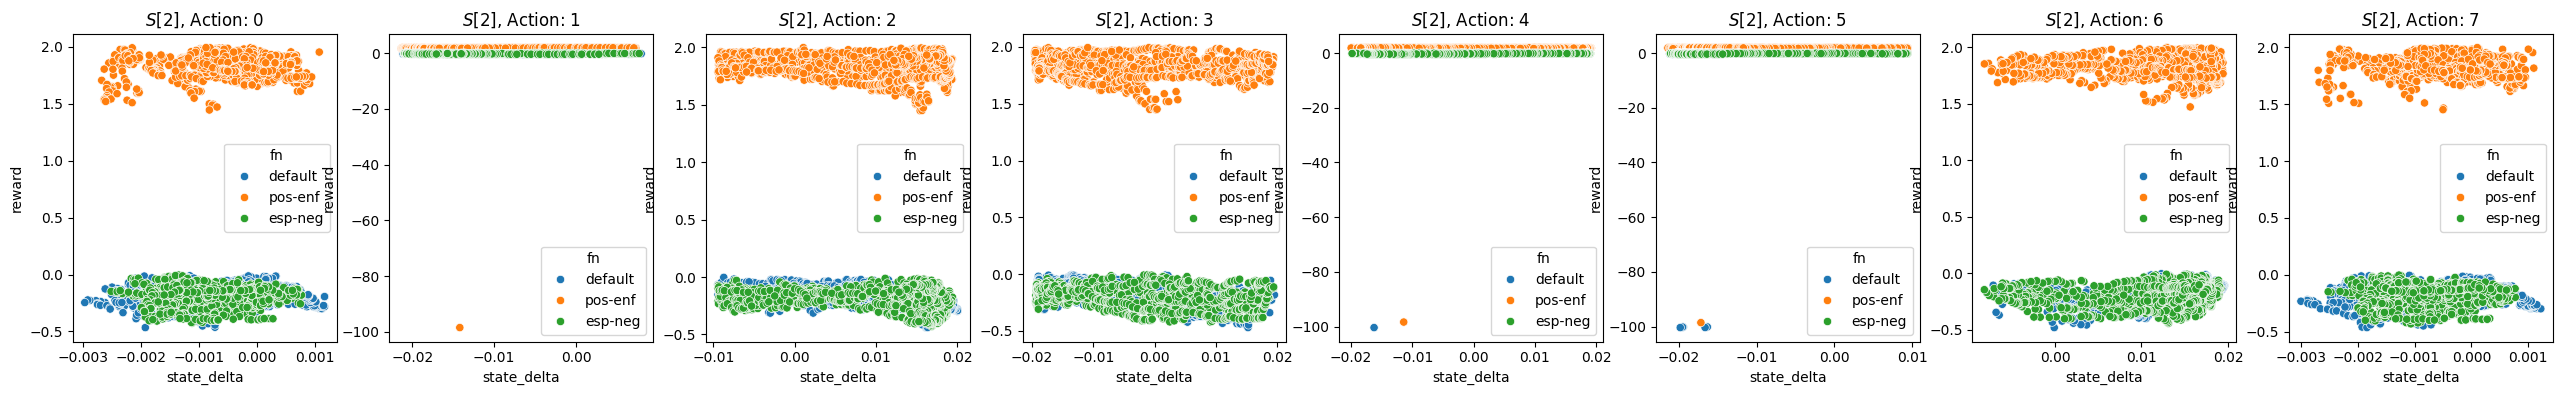

In [36]:
plot_state_change_rewards(df_obs_rew, state_idx=2)

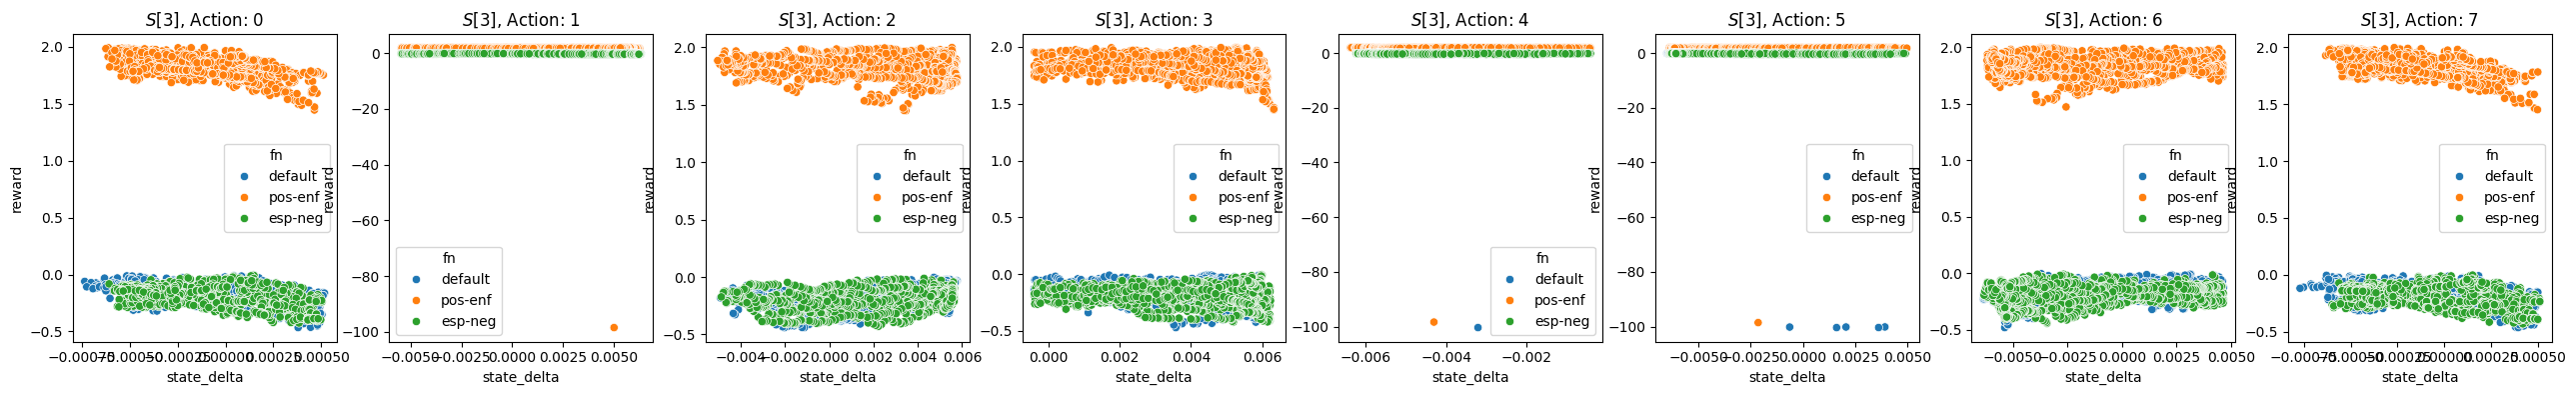

In [37]:
plot_state_change_rewards(df_obs_rew, state_idx=3)